# Business Case

## Problem

The marketing department was pressured to spend its annual budget more wisely. The CMO perceives the importance of having a more quantitative approach when taking decisions, reason why a small team of data scientists was hired with a clear objective in mind: to build a predictive model which will support direct marketing initiatives. Desirably, the success of these activities will prove the value of the approach and convince the more skeptical within the company.

## Goal

The objective of the team is to build a predictive model that will produce the highest profit for the next direct marketing campaign, scheduled for the next month. The new campaign, sixth, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving 2.240 customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled. The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. Globally the campaign had a profit of -3.046MU. The success rate of the campaign was 15%. The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base. Hopefully, the model will allow the company to cherry pick the customers that are most likely to purchase the offer while leaving out the non-respondents, making the next campaign highly profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in understanding to study the characteristic features of those customers who are willing to buy the gadget.

## Deliverables

Explore the data – be creative and pay attention to the details. You need to provide the marketing team a better understanding of the characteristic features of respondents;
Create and describe a customer segmentation based on customers behaviors;
Create and describe a predictive model (classification) which allows the company to maximize the profit of the next marketing campaign.


# Project Development Methodology

The project was developed based on the CRISP-DS (Cross-Industry Standard Process - Data Science, a.k.a. CRISP-DM) project management method, with the following steps:

**Step 01. Data Description**

**Step 02. Feature Engineering**

**Step 03. Data Filtering**

**Step 04. Exploratory Data Analysis**

**Step 05. Data Preparation**

**Step 06. Feature Selection**

**Step 07. Machine Learning Modelling** - Classification

**Step 08. Convert Model Performance to Business Values** - Classification

**Step 09. Machine Learning Modelling** - Clustering

**Step 10. Convert Model Performance to Business Values** - Clustering



# Setup

## Imports

In [1]:
import pickle
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import scikitplot            as skplt
import scikitplot            as skplt
from scipy                   import stats
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from boruta                  import BorutaPy
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.cluster         import KMeans
from pycaret.datasets        import get_data
from sklearn.metrics         import classification_report
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer 

import warnings 
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 ,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

# Logistic Regression Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test set function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                                   }, index=[model_name])
    
    return performance_df

def precision_at_k( data, k=224, model_name=str):
    '''
    --> Calculate the model precision at the k position in ranking
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the precision
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    print The precison at k ranking position
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['Response'].cumsum() / data['ranking']

    print(f"Model: {model_name} \nRanking Position: {k} \nPrecison: {round(data.loc[k, 'precision_at_k'], 2)}") 

## Loading Data

In [3]:
data_raw = pd.read_csv('data/ml_project1_data.csv')

# STEP 01 - Data Description

In [4]:
df1 = data_raw.copy() 

In [5]:
df1.head() # to visualize some of the data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


 **Features descripion**
    
 0   ID                   - customer's id  
 
 1   Year_Birth           - year of birth of client
 
 2   Education            - customer's level of education 
 
 3   Marital_Status       - customer's marital status
 
 4   Income               - customer's yearly household income
 
 5   Kidhome              - number of small children in customer's household
 
 6   Teenhome             - number of teenagers in customer's household
 
 7   Dt_Customer          - date of customer's enrollment with the company
 
 8   Recency              - number of days since the last purchase
 
 9   MntWines             - amount spent on wines in the last 2 years
 
 10  MntFruits            - amount spent on fruits in the last 2 years
 
 11  MntMeatProducts      - amount spent on meat in the last 2 years 
 
 12  MntFishProducts      - amount spent on fish in the last 2 years
 
 13  MntSweetProducts     - amount spent on sweet in the last 2 years  
 
 14  MntGoldProds         - amount spent on gold in the last 2 years 
 
 15  NumDealsPurchases    - number of purchases made with discount  
 
 16  NumWebPurchases      - number of purchases made through company's website 
 
 17  NumCatalogPurchases  - number of purchases made using catalog  
 
 18  NumStorePurchases    - number of purchases made directly in stores 
 
 19  NumWebVisitsMonth    - number of visits made to company's website in the last month  
 
 20  AcceptedCmp3         - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise 
 
 21  AcceptedCmp4         - 1 if customer accepted the offer in the 4th campaign, 0 otherwise  
 
 22  AcceptedCmp5         - 1 if customer accepted the offer in the 5th campaign, 0 otherwise 
 
 23  AcceptedCmp1         - 1 if customer accepted the offer in the 1st campaign, 0 otherwise 
 
 24  AcceptedCmp2         - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise   
 
 25  Complain             - 1 if customer complained in the last 2 years  
 
 26  Response             - 1 if customer accepted the offer in the last campaign, 0 otherwise 

## Data Dimension

In [6]:
df1.info() 
# to know the number of data entries in the dataset, 
# the type of the data in each columns and if there is any null value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From this info, it is possible to see that in the 'Income' column there are 24 null values. (2240-2216)=24

## Change Type

In [7]:
# Convert ot datetime
df1['Dt_Customer']= pd.to_datetime(df1['Dt_Customer'])

## Check NaN

In [8]:
df1.isna().sum() # to make sure where the 'na' values are.

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Since there are only 24 NaNs in the dataset, I will use the median of the Income column for the missing values.

In [21]:
df2['Income'] = df2['Income'].fillna(df2['Income'].median())

## Descriptive Statistics

### Numerical Attributes

In [9]:
num_attributes = df1.select_dtypes(include=['int64', 'float64']) 
# numerical attributes are the ones with numerical data type.

In [10]:
num_attributes = num_attributes.drop(['ID', 'Year_Birth'], axis=1)
# the ID column and year of birth have no effect in this analysis

In [11]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0
MntGoldProds,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0


### Categorical Attributes

In [12]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64']) 
# numerical attributes are the ones that are not numerical data type.

In [17]:
pd.DataFrame(df1['Education'].value_counts())

,Education
Graduation,1127
PhD,486
Master,370
2n Cycle,203
Basic,54


In [18]:
pd.DataFrame(df1['Marital_Status'].value_counts())

,Marital_Status
Married,864
Together,580
Single,480
Divorced,232
Widow,77
Alone,3
Absurd,2
YOLO,2


# STEP 02 - Feature Engineering

In [19]:
df2 = df1.copy()

## Hipothesis

1.	Customers with higher Income have more probability to accept the offer
2.	Customers with higher values of recency have less probability to accept the offer
3.	Customers with higher age have more probability to accept the offer
4.	Customers who are married have more probability to accept the offer
5.	Customers who have teenagers have less probability to accept the offer
6.	Customers who have small kids have less probability to accept the offer
7.	Customers with basic education have more probability to accept the offer
8.	Customers with older enrollment with the company (high tenure) have more probability to accept the offer
9.	Customers with no complaints with the company have more probability to accept the offer
10.	Customers who bought more gold products have more probability to accept the offer
11.	Customers who bought more wine have more probability to accept the offer
12.	Customers who spent more, have more probability to accept the offer
13.	Customers with higher number of purchases with discount have less probability to accept the offer
14.	Customers with higher number of purchases have more probability to accept the offer
15.	Customers with higher number of visits in the company's website have more probability to accept the offer
16.	Customers who accepted more offers have more probability to accept the offer

## Feature Engineering

* Create an AGE column in the dataset, because it is better to work with than 'year of birth' for statistical purposes.

In [20]:
# AGE - age of the custumers 

# The maximum year of the dateset to calculate the age of the customers at the time.
df2['Dt_Customer'].max().year

# including the Age column in the dateset.
df2['Age'] = df2['Dt_Customer'].max().year - df2['Year_Birth']

* Create de TENURE attribute to better analyse how many years the customers is enrolled with the company.

In [22]:
# TENURE (in years) - years of customer's enrollment with the company

df2['Tenure'] = (df2['Dt_Customer'].max() - df2['Dt_Customer'])/ np.timedelta64(1, 'Y')

# divided by np.timedelta64(1, 'Y') to convert the values from days to years.

* Create TOTAL AMOUT SPENT column to sum the total customer's spent.


In [24]:
# TOTAL AMOUNT SPENT

df2['Total_Amount_Spent'] = df2['MntWines'] + df2['MntFruits']+ df2['MntMeatProducts'] + \
df2['MntFishProducts'] + df2['MntSweetProducts'] + df2['MntGoldProds']

* Create TOTAL NUMBER OF PURCHASES column to sum the total number of purchases the customer's did.

In [25]:
# TOTAL NUMBER OF PURCHASES

df2['Total_Num_Purchases'] = df2['NumDealsPurchases'] + df2['NumWebPurchases'] + \
df2['NumCatalogPurchases'] + df2['NumStorePurchases']

* Create TOTAL NUMBER OF ACCEPTED CAMPAIGNS column to sum the total number of campaigns the customer accepted.

In [27]:
# TOTAL NUMBER OF ACCEPTED CAMPAIGNS

df2['Total_Acp_Cmp'] = df2['AcceptedCmp1'] + df2['AcceptedCmp2'] + df2['AcceptedCmp3'] + \
df2['AcceptedCmp4'] + df2['AcceptedCmp5']

# STEP 03 - Data Filtering

In [28]:
df3 = df2.copy()

From the descriptive statistics and feature engineering, it is possible to make some observations to filter some of the data.

## Row selection

* Age (Age <= 100):
Age column show that the maximum value is 121 years, so we are going to filter this column to values less or equal to 100 years.



In [29]:
df3 = df3[df3['Age'] <= 100]

* Income (Income <> 666666.0):
This value in the income column is a very high number and very distant from the other data, which can be assumed as a typing error.
So, i am going to set this value to the income median, better than exclude this row.

In [30]:
df3.loc[df3['Income'] == 666666, 'Income'] = df3['Income'].median()

## Column Selection

* Eliminate 'Dt_Customer' :
replaced by tenure column

* Eliminate 'Year_Birth' :
replaced by  age column

* Eliminate 'Z_CostContact' :
there is no variance in the data

* Eliminate 'Z_Revenue' :
there is no variance in the data

In [32]:
cols_drop = ['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue']
df3 = df3.drop(cols_drop, axis=1)

# STEP 04 - Exploratory Data Analysis

In [33]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

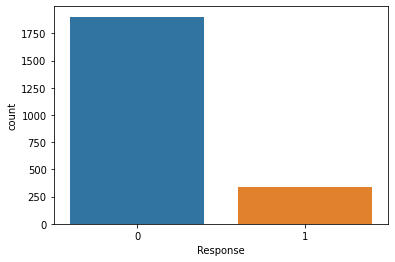

In [34]:
sns.countplot(x=df4['Response']);

In [35]:
pd.DataFrame(df4['Response'].value_counts())

,Response
0,1903
1,334


In [36]:
pd.DataFrame(df4['Response'].value_counts(normalize=True))

,Response
0,0.850693
1,0.149307


In [37]:
num_acp_cmp = df4[df4['Response'] == 1].shape[0] # Number of clients that accepted the offer
num_not_acp_cmp = df4[df4['Response'] == 0].shape[0] # Number of clients that did not accept the offer

response_rate = (num_acp_cmp/(num_acp_cmp+num_not_acp_cmp))*100

print('Response rate of the last campaign is {0:.2f}%.'.format(response_rate))

Response rate of the last campaign is 14.93%.


### Numerical Attributes

In [38]:
# Update the nummerical attributes to include the features created.

num_attributes = df3.select_dtypes(include=['int64', 'float64']) 

num_attributes = num_attributes.drop(['ID', 'Response'], axis=1)

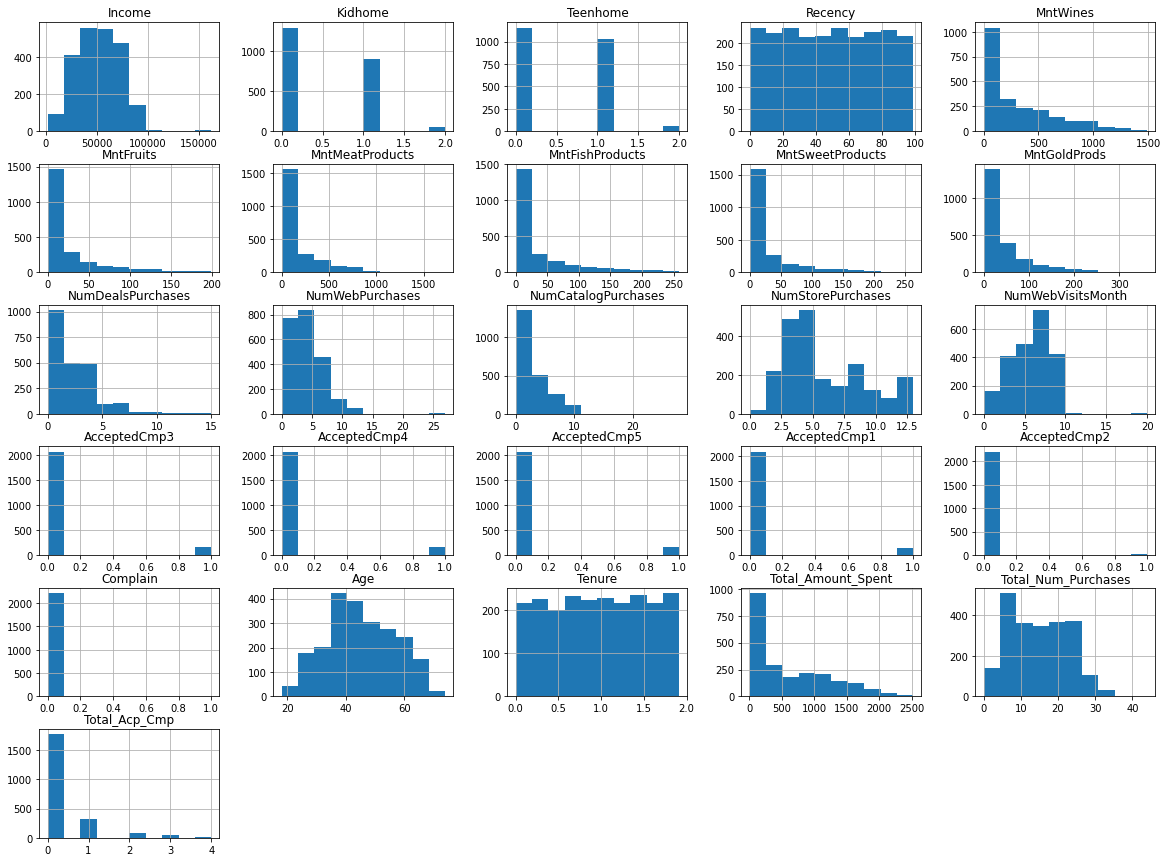

In [39]:
num_attributes.hist(figsize=(20, 15));

### Categorical Attributes

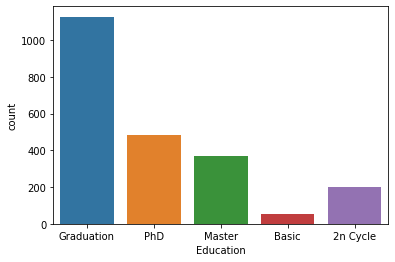

In [40]:
# Plot - 'Education'

sns.countplot(x=df4['Education']);

In [41]:
pd.DataFrame(df4['Education'].value_counts(normalize=True))

,Education
Graduation,0.503800
PhD,0.216808
Master,0.165400
2n Cycle,0.089852
Basic,0.024139


* The most popular level of education that the customers have is Graduation, which accounts for 50.38% of all costumers.
* The costumers with basic education represents only 2.41% of the costumers.

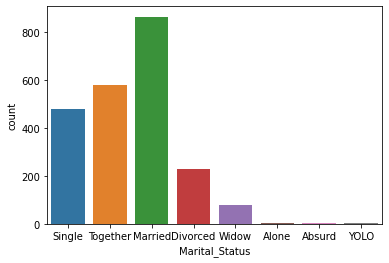

In [42]:
# Plot - 'Marital Status'

sns.countplot(x=df4['Marital_Status']);

In [43]:
pd.DataFrame(df4['Marital_Status'].value_counts(normalize=True))

,Marital_Status
Married,0.386232
Together,0.258829
Single,0.214126
Divorced,0.103263
Widow,0.034421
Alone,0.001341
Absurd,0.000894
YOLO,0.000894


* Married is the marital status that has more occurrency, which accounts for 38.62% of the dataset.
* 0.0894% of the costumers answered their marital status is YOLO (you only live once) and Absurd.

## Bivariate Analysis

### Hipothesis

##### 1. Customers with higher Income have more probability to accept the offer.

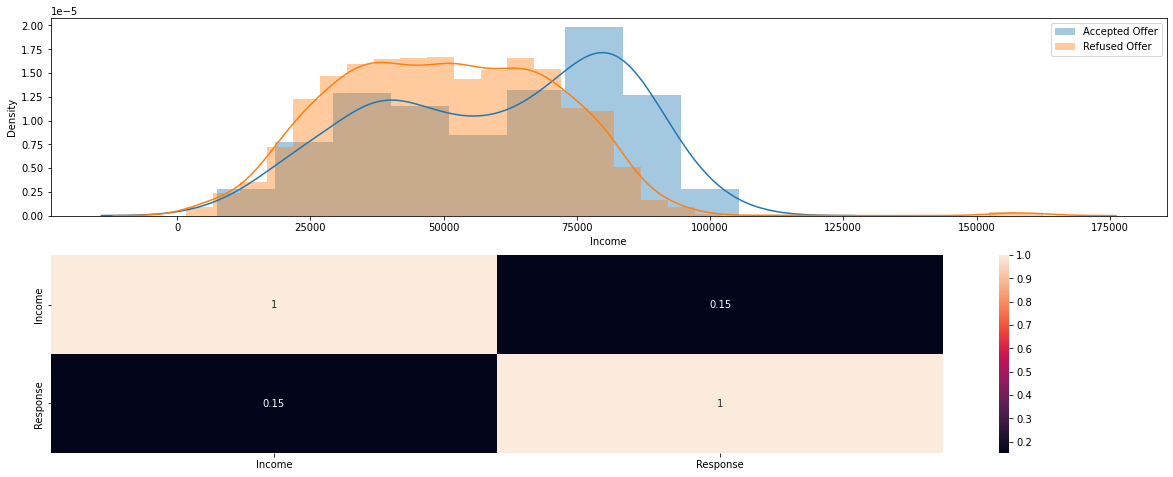

In [44]:
# image size
plt.figure(figsize=(20,8));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Income'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Income'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Income', 'Response']].groupby('Income').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In the distribution plot, the region where the costumer's income is lower the density of costumers who refused the offer is slightly higher than the density of the ones who accepted the offer. As the value of customer's income increases, the density of costumers who accepted the offer is greater than the density of costumers who refused the offers. In sum, costumers with higher income have more probability to accept the offer. The correlation between the Income and response variable has a value of 0.15, which is a positivo correlation but quite weak.

**TRUE**

##### 2. Customers with higher values of recency have less probability to accept the offer.

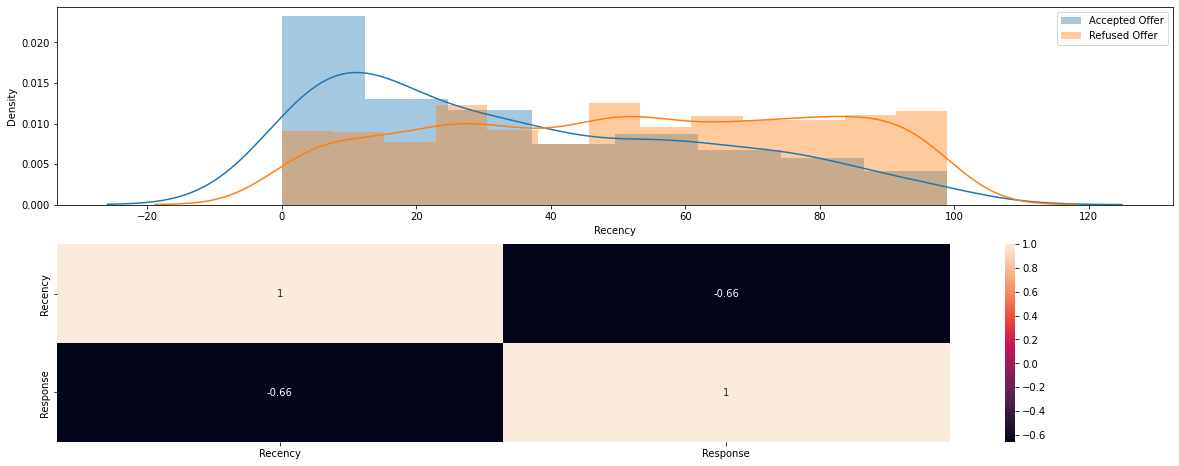

In [45]:
# image size
plt.figure(figsize=(20,8));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Recency'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Recency'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Recency', 'Response']].groupby('Recency').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

The customers tend to accept the offer more when their recency is lower. On the other hand, as the recency increases, the rate of refused offers surpass the rate of accepted offers. As shown in the heatmap, that their correlation is negative with a value of -0.66.

**TRUE**

##### 3. Customers with higher age have more probability to accept the offer

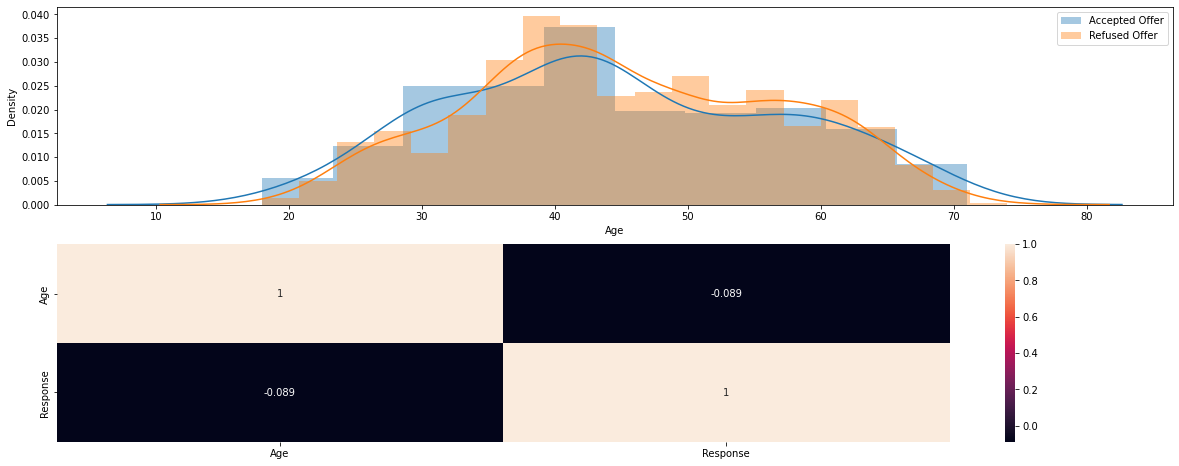

In [46]:
# image size
plt.figure(figsize=(20,8));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Age'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Age'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Age', 'Response']].groupby('Age').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

The distribution of age for accepted offers and refused offers have the same distribution pattern, which means that the age has almost no effect in the decision of whether to accept the offer or not. The correlation coefficient of -0.089 shows that is a weak correlation between these variables.

**FALSE**

##### 4. Customers who are married have more probability to accept the offer.

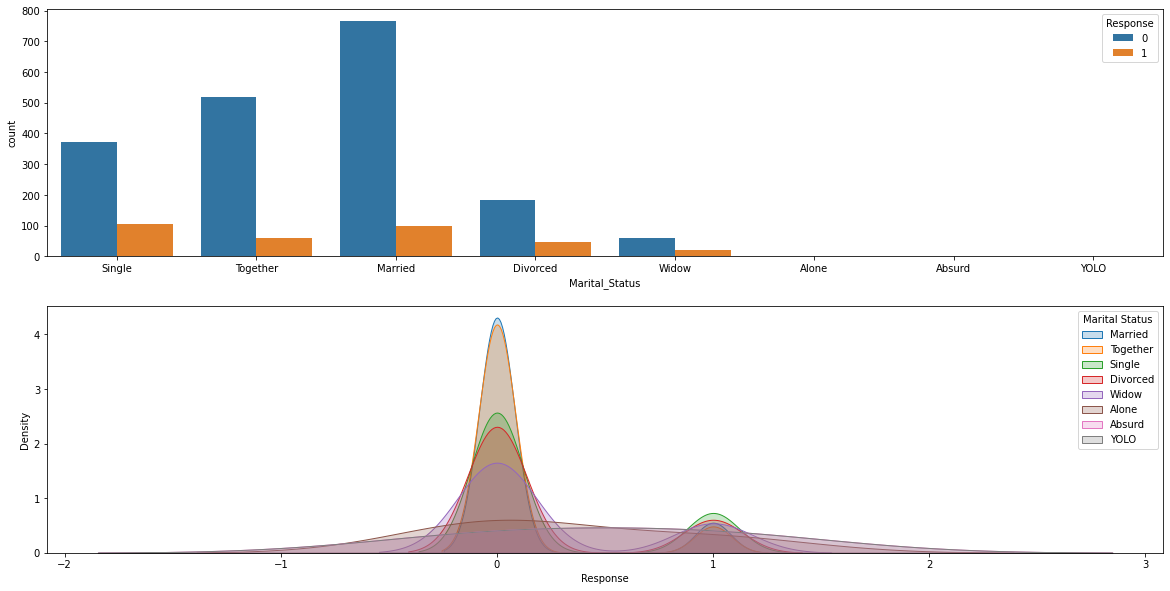

In [48]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Marital_Status', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Marital_Status'] == 'Married']['Response'], label='Married', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Together']['Response'], label='Together', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Single']['Response'], label='Single', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Divorced']['Response'], label='Divorced', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Widow']['Response'], label='Widow', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Alone']['Response'], label='Alone', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'Absurd']['Response'], label='Absurd', shade=True)
sns.kdeplot(df4[df4['Marital_Status'] == 'YOLO']['Response'], label='YOLO', shade=True)
plt.legend(title='Marital Status');

Married status represents 38.62% of the marital status of the customers. However, the plot shows that custumers who are married tend to refuse the campaigns offers, as well as, the costumers who have marital status of Together. In the distribution plot is more clear to observe that customers who are single, tend to accept the offers more than the other marital status. 

**FALSE**

##### 5. Customers who have less teenagers have more probability to accept the offer.

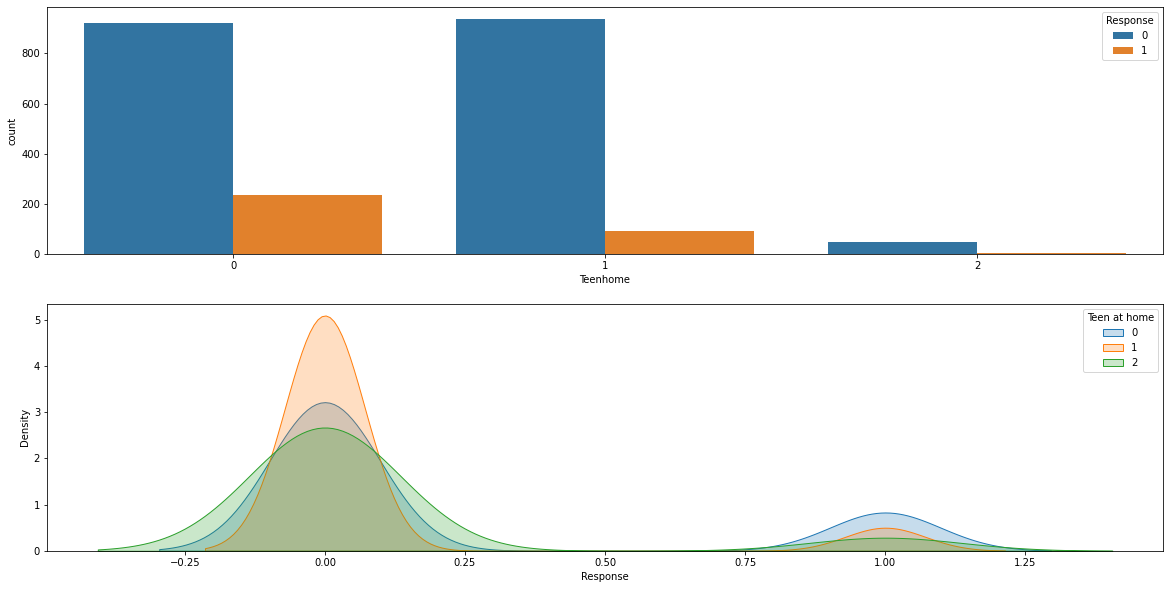

In [49]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Teenhome', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Teenhome'] == 0]['Response'], label='0', shade=True)
sns.kdeplot(df4[df4['Teenhome'] == 1]['Response'], label='1', shade=True)
sns.kdeplot(df4[df4['Teenhome'] == 2]['Response'], label='2', shade=True)
plt.legend(title='Teen at home');

In [50]:
df4['Teenhome'].value_counts(normalize=True).reset_index()

,index,Teenhome
0,0,0.516764
1,1,0.459991
2,2,0.023245


The customer's database shows that 51.67% of the customers dont' have teenager at home, 45.99% have 1 teenager and 2.32% have 2 teenagers. The plot shows that, as the number of teenager at home increases, the probability of the costumer to accept the offer decreases.

**TRUE**

##### 6. Customers who have less small children have more probability to accept the offer.

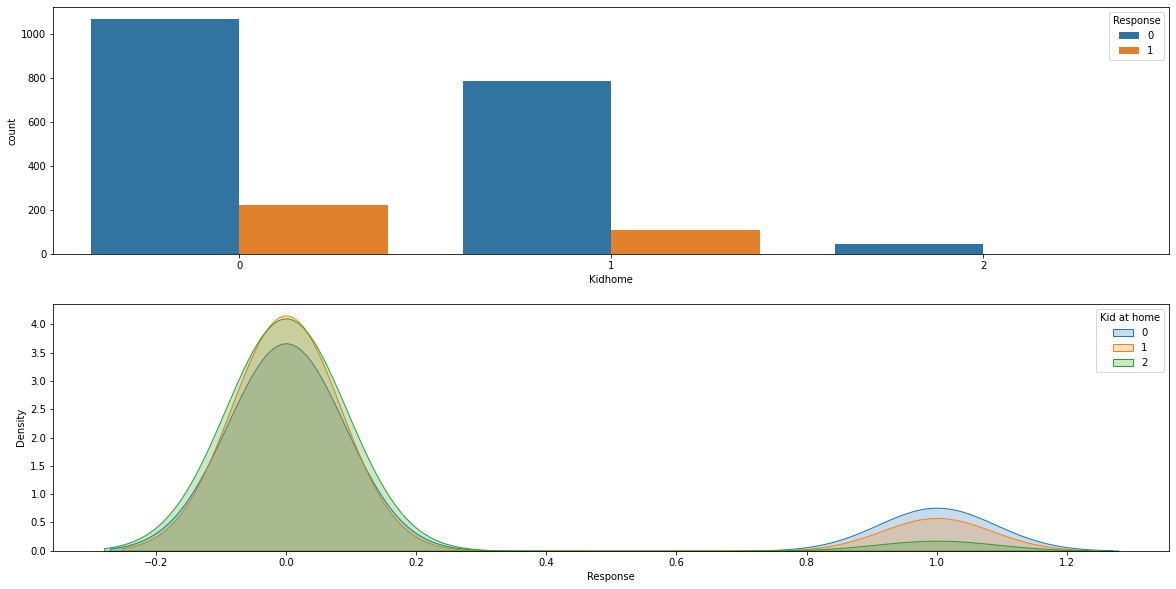

In [51]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Kidhome', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Kidhome'] == 0]['Response'], label='0', shade=True)
sns.kdeplot(df4[df4['Kidhome'] == 1]['Response'], label='1', shade=True)
sns.kdeplot(df4[df4['Kidhome'] == 2]['Response'], label='2', shade=True)
plt.legend(title='Kid at home');

In [52]:
df4['Kidhome'].value_counts(normalize=True).reset_index()

,index,Kidhome
0,0,0.577112
1,1,0.401430
2,2,0.021457


The customer's database shows that 57.71% of the customers dont' have small children at home, 40.14% have 1 teenager and 2.32% have 2 small children. The plot shows that, as the number of small children at home increases, the probability of the costumer to accept the offer decreases.

**TRUE**

##### 7. Customers with graduation have more probability to accept the offer.

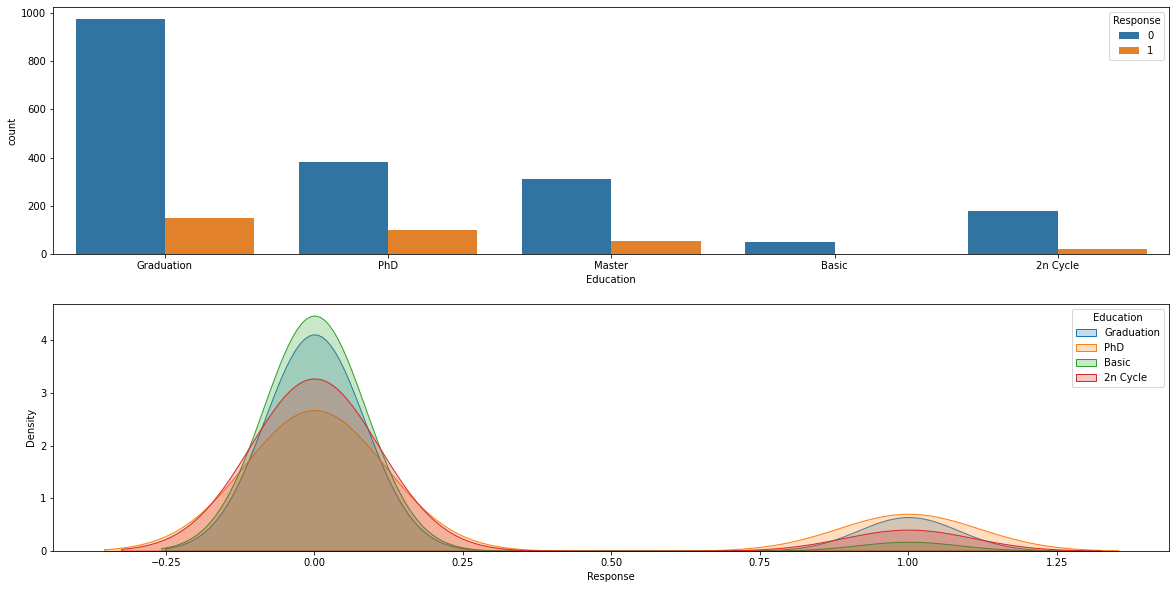

In [53]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Education', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Education'] == 'Graduation']['Response'], label='Graduation', shade=True)
sns.kdeplot(df4[df4['Education'] == 'PhD']['Response'], label='PhD', shade=True)
sns.kdeplot(df4[df4['Education'] == 'Master Education']['Response'], label='Master Education', shade=True)
sns.kdeplot(df4[df4['Education'] == 'Basic']['Response'], label='Basic', shade=True)
sns.kdeplot(df4[df4['Education'] == '2n Cycle']['Response'], label='2n Cycle', shade=True)
plt.legend(title='Education');

From the plot it is possible to observe that customers who have any kind of higher education above basic education have more tendency to accept the offers. Costumers with PhD and Graduation are more likely to accecpt the offer. On the other hand, customers with basic education have more probability to refuse the offers.

**TRUE**

##### 8. Customers with older enrollment with the company (high tenure) have more probability to accept the offer.

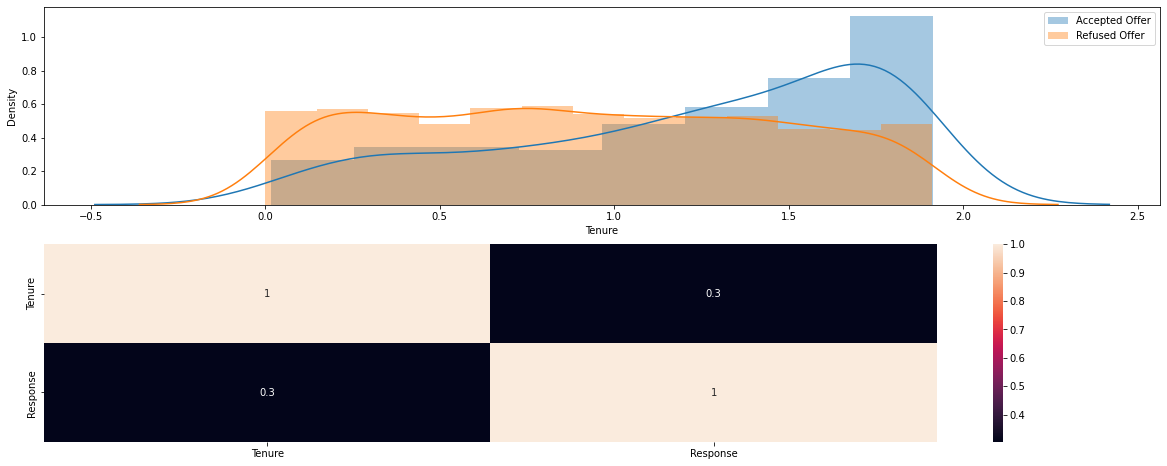

In [55]:
# image size
plt.figure(figsize=(20,8));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Tenure'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Tenure'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Tenure', 'Response']].groupby('Tenure').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

The density distribution plot of tenure shows that when a customer have a older enrollment with the company, they tend to accept the campaign offer compared to the ones that are more recently enrolled. This is proven by the heatmap plot, showing that these variables correlation have a coefficient of 0.3.

**TRUE**

##### 9. Customers with no complaints with the company have more probability to accept the offer.

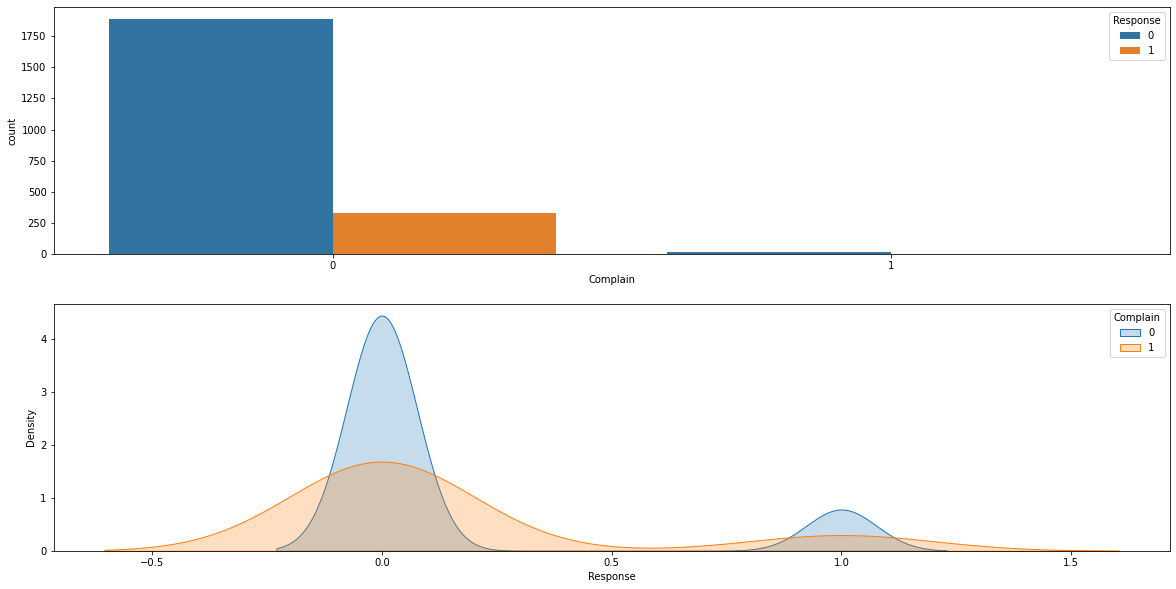

In [56]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Complain', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Complain'] == 0]['Response'], label='0', shade=True)
sns.kdeplot(df4[df4['Complain'] == 1]['Response'], label='1', shade=True)
plt.legend(title='Complain');

In [57]:
df4['Complain'].value_counts(normalize=True).reset_index()

,index,Complain
0,0,0.991059
1,1,0.008941


99.10% of the customer's have done zero compaints for the company. To increase the probability for the costumer to accept the offer, is shown in the plot that it must have done no complaints in the last 2 years.

**TRUE**

##### 10. Customers who bought more gold products have more probability to accept the offer.

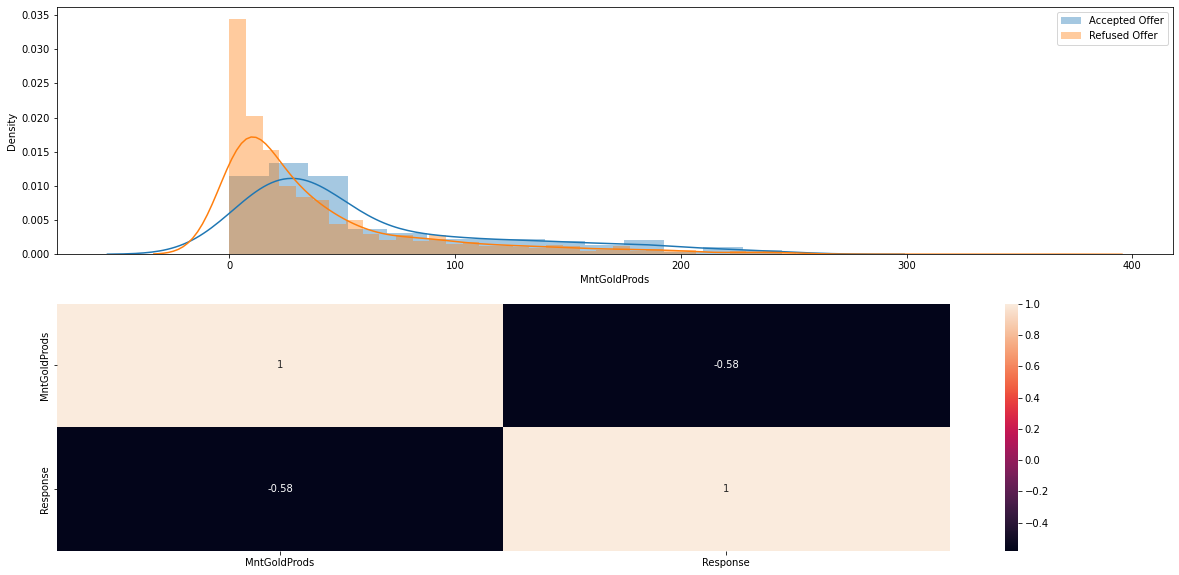

In [58]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['MntGoldProds'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['MntGoldProds'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['MntGoldProds', 'Response']].groupby('MntGoldProds').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);



Overall, it is possible to say from the distribution plot that the probability of accepting an offer when a customer has bought some amount of gold products is true. For customers who purchased zero or very low amount of gold producs, the occurrence of refused offers surpasses the accepted offers. The coefficient of correlation (-0.58)shows that the correlation is negative and medium strong between 'amount spent on gold products' and the reponse variable. 

**TRUE**

##### 11. Customers who bought more wine have more probability to accept the offer.

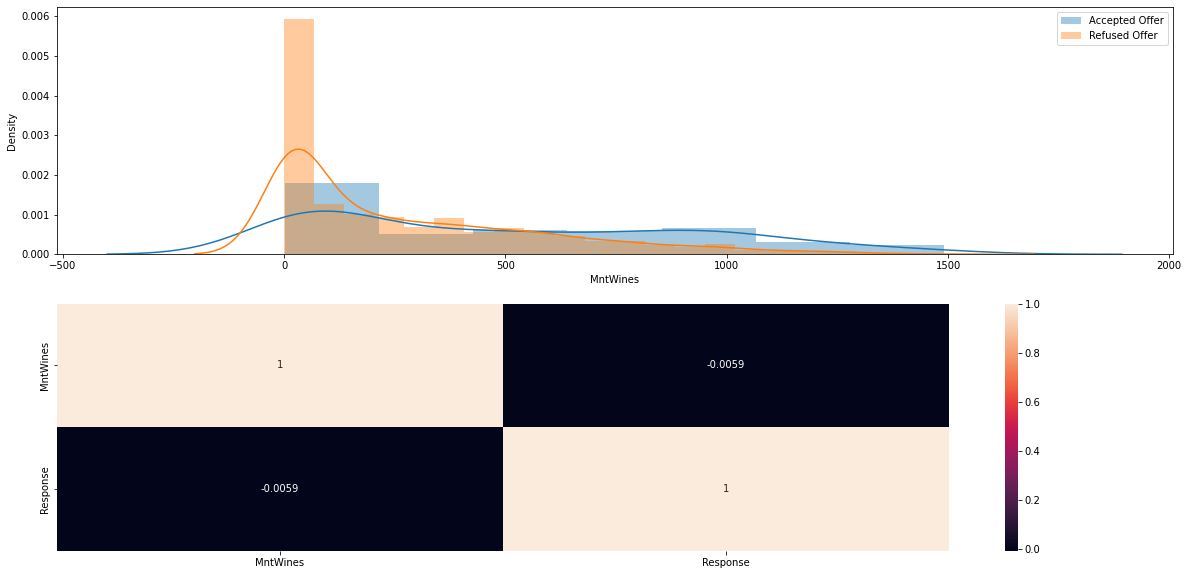

In [59]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['MntWines'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['MntWines'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['MntWines', 'Response']].groupby('MntWines').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

As the amount of wines purchased by the customers increase, the chance of of accepting the offer also increases. On the other hand, amount of wines purchased by the customers decrease, the chance of of accepting the offer also decreases. However, even though the distribution plot showed a small correlation with these variables, the heatmap shows that this correlation is very weak with a coefficient of -0.0059.

**TRUE**

##### 12. Customers who spent more, have more probability to accept the offer.

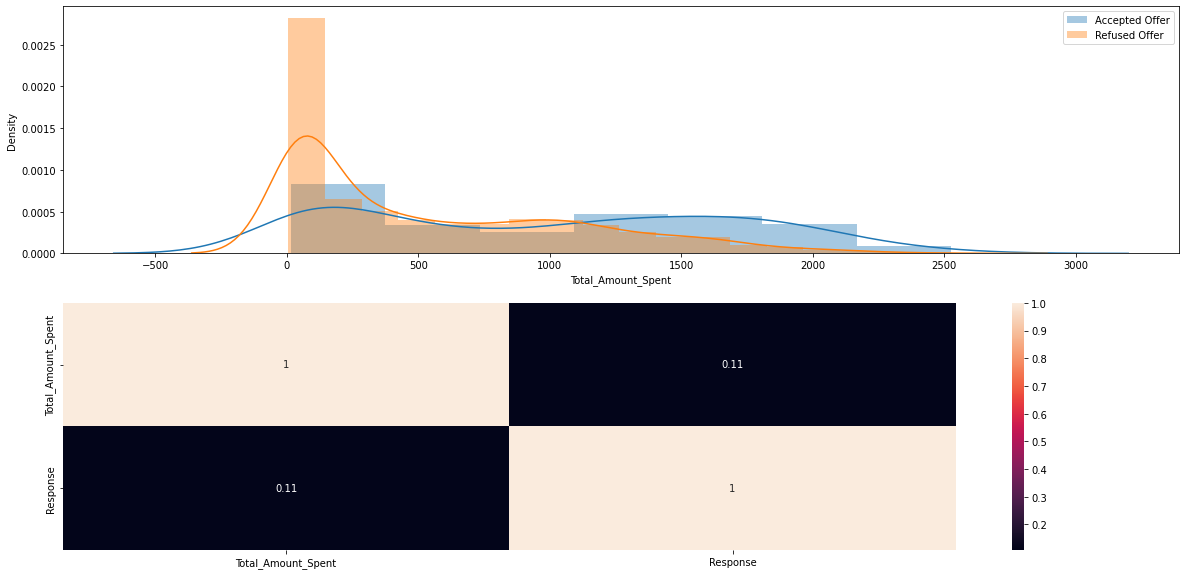

In [61]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Total_Amount_Spent'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Total_Amount_Spent'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Total_Amount_Spent', 'Response']].groupby('Total_Amount_Spent').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Overall, it is possible to say from the distribution plot that the probability of accepting an offer when a customer has spent more in the company increases. For customers who spent zero or very low amount, the chance of refused offers surpasses the accepted offers. The correlation coeficient of 0.11 between those variables show that they have a positive correlation, but quite weak. 

**TRUE**

##### 13. Customers with higher number of purchases with discount have less probability to accept the offer.

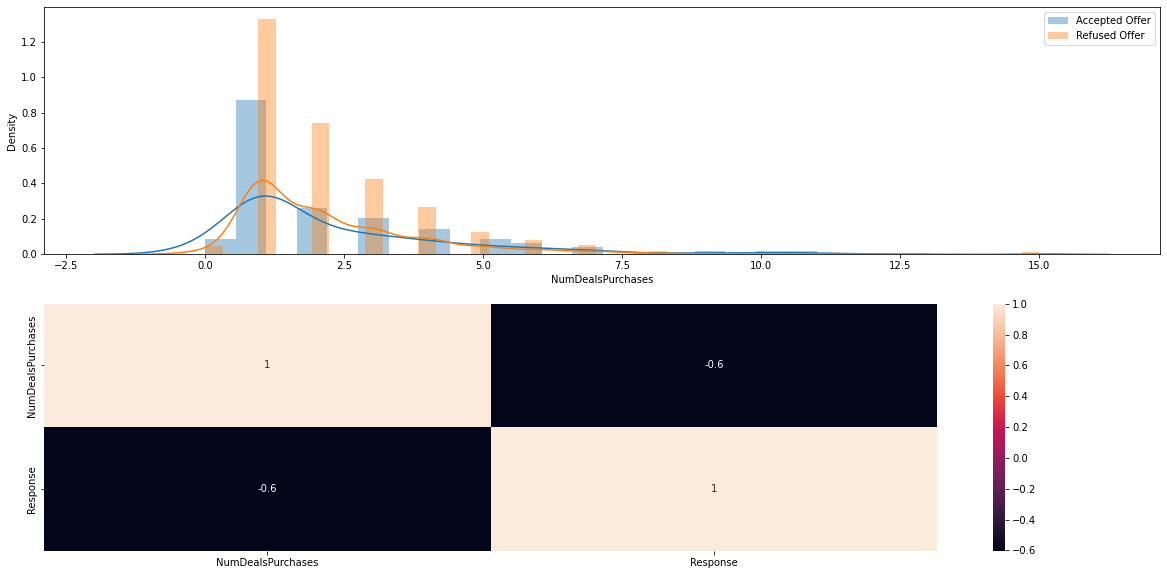

In [62]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['NumDealsPurchases'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['NumDealsPurchases'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['NumDealsPurchases', 'Response']].groupby('NumDealsPurchases').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

As the number of purchases with discount by the customers increases, the chance of accepting the offer slightly decreases. As the heatmap shows, that the variables have a negative correlation. 

**FALSE**

##### 14.	Customers with higher number of purchases have more probability to accept the offer.

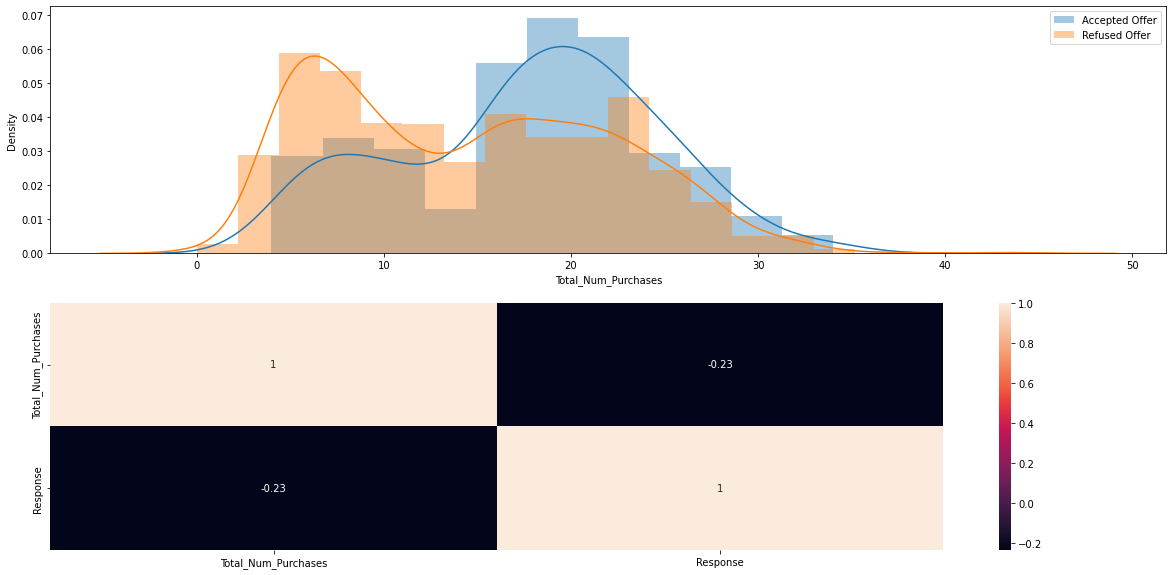

In [63]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['Total_Num_Purchases'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['Total_Num_Purchases'], kde=True, label='Refused Offer');
plt.legend();

plt.subplot(2,1,2)
aux1 = df4[['Total_Num_Purchases', 'Response']].groupby('Total_Num_Purchases').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

From the plot it is possible to observe at a certain point this hipothesis is true, that customers who purchased have more probability to accept the offer than the ones who bought less. However, at the maximum values of total number of purchases, the chance of refusing and accepting the offer have almost the same behaviour. Additionally, the heatmap shows that the correlation between these variables is negative, which contradicts the hypothesis.

**FALSE**

##### 15. Customers with higher number of visits in the company's website have more probability to accept the offer.

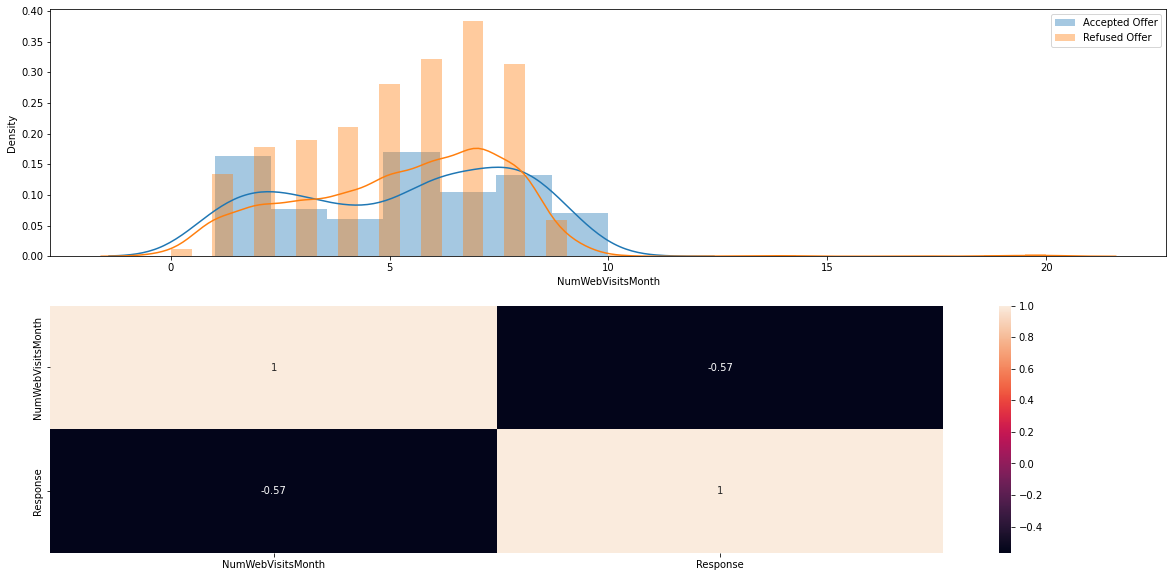

In [64]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.distplot(df4[df4['Response'] == 1]['NumWebVisitsMonth'], kde=True, label='Accepted Offer');
sns.distplot(df4[df4['Response'] == 0]['NumWebVisitsMonth'], kde=True, label='Refused Offer');
plt.legend();


plt.subplot(2,1,2)
aux1 = df4[['NumWebVisitsMonth', 'Response']].groupby('NumWebVisitsMonth').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Overall, as the number of website increases, the chance of getting a refused offer also increases. The heatmap shows that the correlation is -0.57, which proves that as the number of website visits increases, the chance of acceptance of the offer decreases. 

**FALSE**

##### 16. Customers who accepted more offers have more probability to accept the offer.

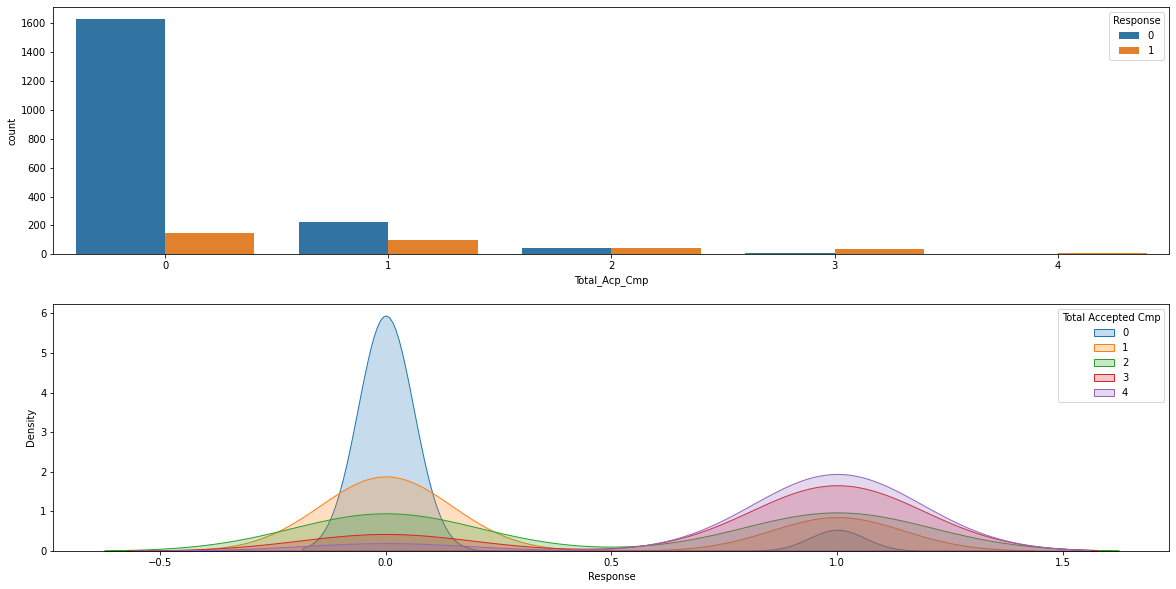

In [65]:
# image size
plt.figure(figsize=(20,10));

# plot
plt.subplot(2,1,1)
sns.countplot(x='Total_Acp_Cmp', hue='Response', data=df4);

plt.subplot(2,1,2)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 0]['Response'], label='0', shade=True)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 1]['Response'], label='1', shade=True)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 2]['Response'], label='2', shade=True)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 3]['Response'], label='3', shade=True)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 4]['Response'], label='4', shade=True)
sns.kdeplot(df4[df4['Total_Acp_Cmp'] == 5]['Response'], label='5', shade=True)
plt.legend(title='Total Accepted Cmp');

In [66]:
df4['Total_Acp_Cmp'].value_counts(normalize=True).reset_index()

,index,Total_Acp_Cmp
0,0,0.793473
1,1,0.144837
2,2,0.037103
3,3,0.019669
4,4,0.004917


79.34% of the customers did not accept an offer yet, and this percentage decreases as the number of accepted offers increases, which only 0.4917% of customers accepted 4 offers. In the distribution plot, it is possible to say that, the probability to accept an offer is higher for customers with higher number of previous accepted campaigns offers. 

**TRUE**

## Multivariate Analysis

### Numerical Attibutes

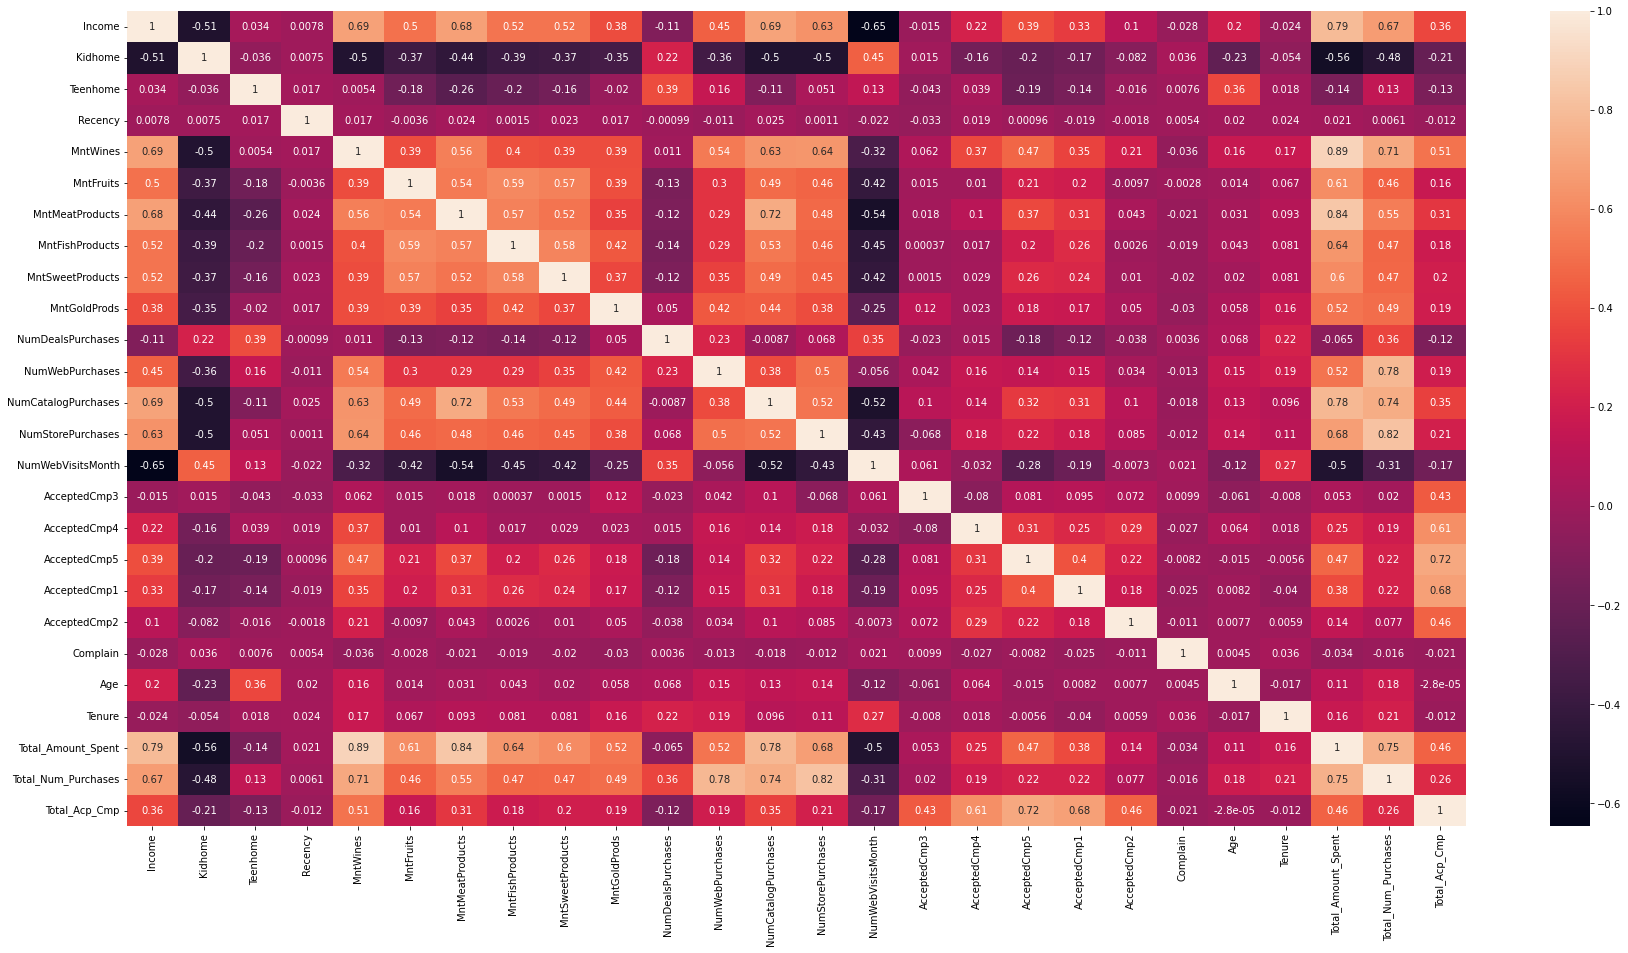

In [67]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(30, 15))
sns.heatmap(correlation, annot=True);

Strong correlations observed:

* Income x NumWebVisitsMonth = -0.65
* Income x Total_Amount_Spent = 0.79
* Income x Total_Number_Purchases = 0.67
* MntWines x Income = 0.69
* MntWines x Total_Amount_Spent = 0.89
* MntWines x Total_Number_Purchases = 0.71
* MntMeatProducts x Total_Amount_Spent = 0.84
* NumWebPurchases x Total_Number_Purchases = 0.78
* NumCatalogPurchases x Total_Amount_Spent = 0.78
* NumStorePurchases x Total_Number_Purchases = 0.82
* Total_Acp_Cmp x AcceptedCmp5 = 0.72

### Categorical Attributes

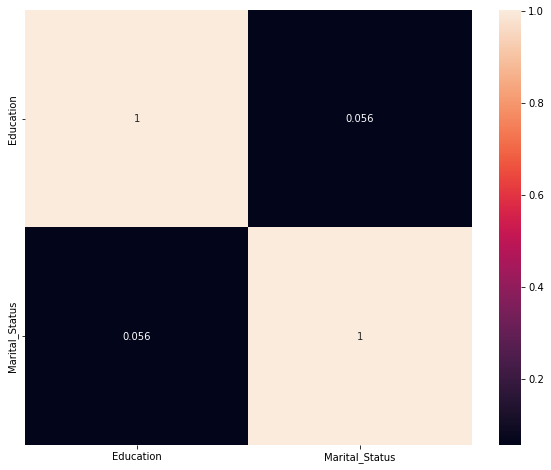

In [69]:
# Only categorical data
aux_cat = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(aux_cat['Education'], aux_cat['Education'])
a2 = cramer_v(aux_cat['Education'], aux_cat['Marital_Status'])

a3 = cramer_v(aux_cat['Marital_Status'], aux_cat['Education'])
a4 = cramer_v(aux_cat['Marital_Status'], aux_cat['Marital_Status'])

# Final dataset
d = pd.DataFrame({'Education': [a1,a2], 
             'Marital_Status': [a3,a4]})

d = d.set_index(d.columns)

#plot
plt.figure(figsize=(10, 8))
sns.heatmap(d, annot=True);

The correlation between Marital Status and Education is very weak, with a coefficient of 0.056.

# STEP 05 - Data Preparation

In [70]:
df5 = df4.copy()

## Check Outliers

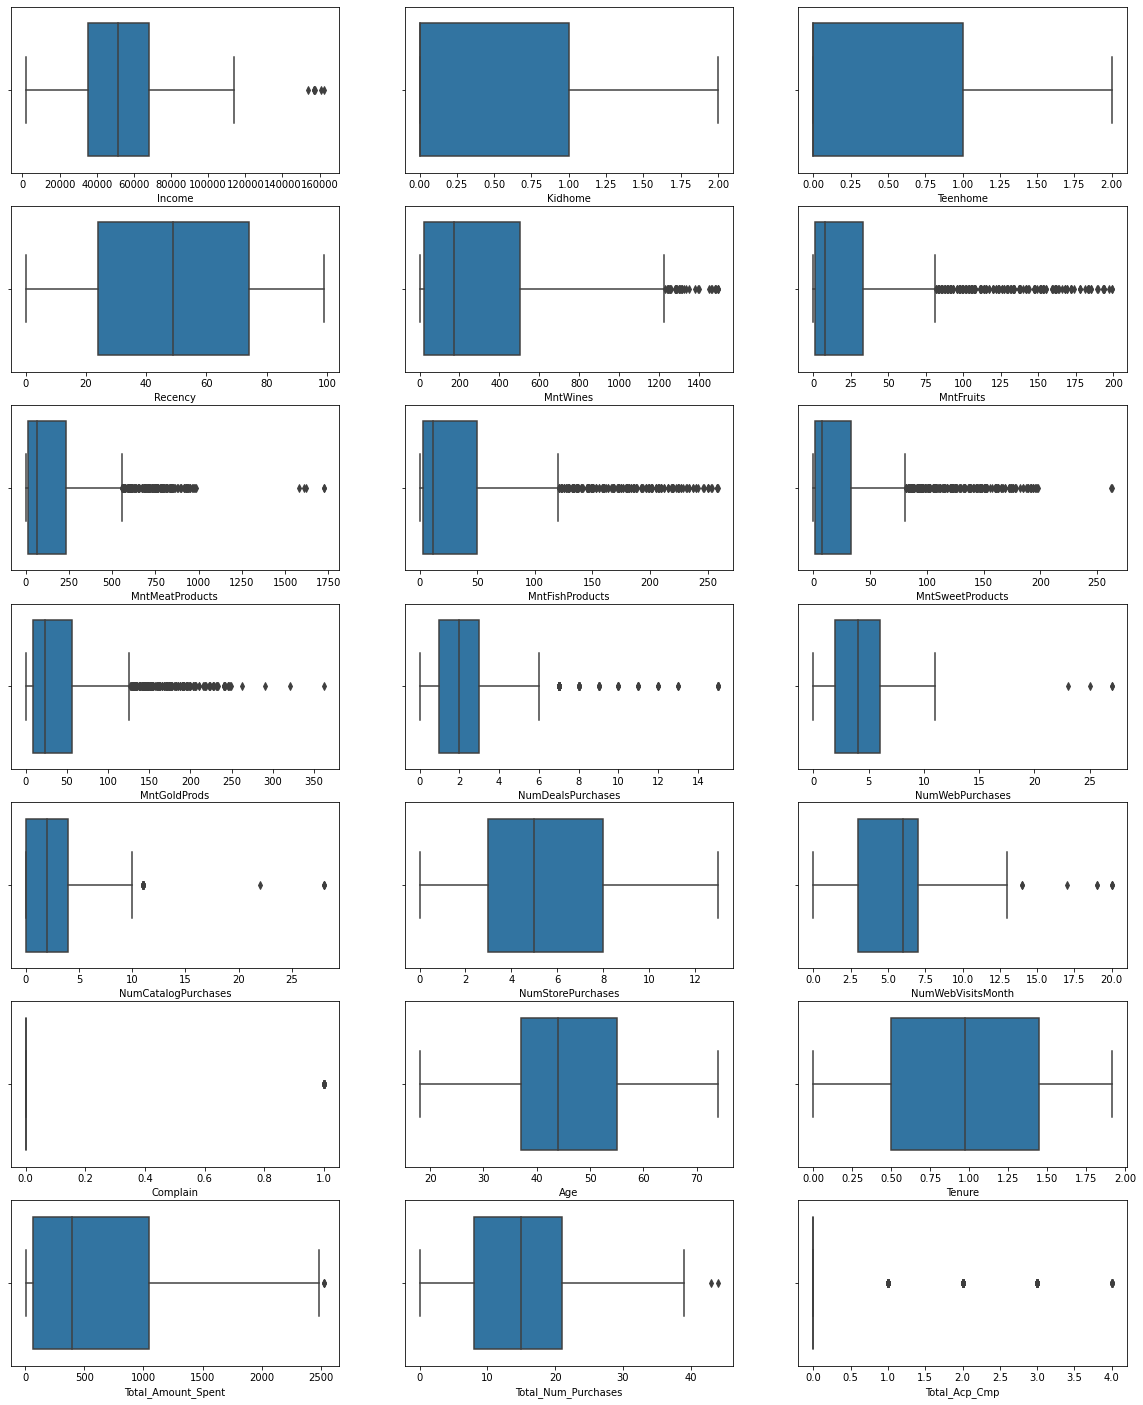

In [71]:
# set up figure size
plt.subplots(figsize=(20,25))

# plot
plt.subplot(7,3,1)
sns.boxplot(df5['Income']);

plt.subplot(7,3,2)
sns.boxplot(df5['Kidhome']);

plt.subplot(7,3,3)
sns.boxplot(df5['Teenhome']);

plt.subplot(7,3,4)
sns.boxplot(df5['Recency']);

plt.subplot(7,3,5)
sns.boxplot(df5['MntWines']);

plt.subplot(7,3,6)
sns.boxplot(df5['MntFruits']);

plt.subplot(7,3,7)
sns.boxplot(df5['MntMeatProducts']);

plt.subplot(7,3,8)
sns.boxplot(df5['MntFishProducts']);

plt.subplot(7,3,9)
sns.boxplot(df5['MntSweetProducts']);

plt.subplot(7,3,10)
sns.boxplot(df5['MntGoldProds']);

plt.subplot(7,3,11)
sns.boxplot(df5['NumDealsPurchases']);

plt.subplot(7,3,12)
sns.boxplot(df5['NumWebPurchases']);

plt.subplot(7,3,13)
sns.boxplot(df5['NumCatalogPurchases']);

plt.subplot(7,3,14)
sns.boxplot(df5['NumStorePurchases']);

plt.subplot(7,3,15)
sns.boxplot(df5['NumWebVisitsMonth']);

plt.subplot(7,3,16)
sns.boxplot(df5['Complain']);

plt.subplot(7,3,17)
sns.boxplot(df5['Age']);

plt.subplot(7,3,18)
sns.boxplot(df5['Tenure']);

plt.subplot(7,3,19)
sns.boxplot(df5['Total_Amount_Spent']);

plt.subplot(7,3,20)
sns.boxplot(df5['Total_Num_Purchases']);

plt.subplot(7,3,21)
sns.boxplot(df5['Total_Acp_Cmp']);

## Rescaling

In [72]:
mms = MinMaxScaler()

# Income
df5['Income'] = mms.fit_transform(df5[['Income']].values )
pickle.dump( mms, open('parameter/Income_scaler.pkl', 'wb'))

# Kidhome
df5['Kidhome'] = mms.fit_transform(df5[['Kidhome']].values )
pickle.dump( mms, open('parameter/Kidhome_scaler.pkl', 'wb'))

# Teenhome
df5['Teenhome'] = mms.fit_transform(df5[['Teenhome']].values )
pickle.dump( mms, open('parameter/Teenhome_scaler.pkl', 'wb'))

# Recency
df5['Recency'] = mms.fit_transform(df5[['Recency']].values )
pickle.dump( mms, open('parameter/Recency_scaler.pkl', 'wb'))

# NumDealsPurchases
df5['NumDealsPurchases'] = mms.fit_transform(df5[['NumDealsPurchases']].values )
pickle.dump( mms, open('parameter/NumDealsPurchases_scaler.pkl', 'wb'))

# NumWebPurchases
df5['NumWebPurchases'] = mms.fit_transform(df5[['NumWebPurchases']].values )
pickle.dump( mms, open('parameter/NumWebPurchases_scaler.pkl', 'wb'))

# NumCatalogPurchases
df5['NumCatalogPurchases'] = mms.fit_transform(df5[['NumCatalogPurchases']].values )
pickle.dump( mms, open('parameter/NumCatalogPurchases_scaler.pkl', 'wb'))

# NumStorePurchases
df5['NumStorePurchases'] = mms.fit_transform(df5[['NumStorePurchases']].values )
pickle.dump( mms, open('parameter/NumStorePurchases_scaler.pkl', 'wb'))

# NumWebVisitsMonth
df5['NumWebVisitsMonth'] = mms.fit_transform(df5[['NumWebVisitsMonth']].values )
pickle.dump( mms, open('parameter/NumWebVisitsMonth_scaler.pkl', 'wb'))

# Complain
df5['Complain'] = mms.fit_transform(df5[['Complain']].values )
pickle.dump( mms, open('parameter/Complain_scaler.pkl', 'wb'))

# Tenure
df5['Tenure'] = mms.fit_transform(df5[['Tenure']].values )
pickle.dump( mms, open('parameter/Tenure_scaler.pkl', 'wb'))

# Total_Amount_Spent
df5['Total_Amount_Spent'] = mms.fit_transform(df5[['Total_Amount_Spent']].values )
pickle.dump( mms, open('parameter/Total_Amount_Spent_scaler.pkl', 'wb'))

# Total_Num_Purchases
df5['Total_Num_Purchases'] = mms.fit_transform(df5[['Total_Num_Purchases']].values )
pickle.dump( mms, open('parameter/Total_Num_Purchases_scaler.pkl', 'wb'))

# Total_Num_Purchases
df5['Total_Acp_Cmp'] = mms.fit_transform(df5[['Total_Acp_Cmp']].values )
pickle.dump( mms, open('parameter/Total_Acp_Cmp_scaler.pkl', 'wb'))

# Age
df5['Age'] = mms.fit_transform(df5[['Age']].values )
pickle.dump( mms, open('parameter/Age_scaler.pkl', 'wb'))

# MntWines
df5['MntWines'] = mms.fit_transform(df5[['MntWines']].values )
pickle.dump( mms, open('parameter/MntWines_scaler.pkl', 'wb'))

# MntFruits
df5['MntFruits'] = mms.fit_transform(df5[['MntFruits']].values )
pickle.dump( mms, open('parameter/MntFruits_scaler.pkl', 'wb'))

# MntMeatProducts
df5['MntMeatProducts'] = mms.fit_transform(df5[['MntMeatProducts']].values )
pickle.dump( mms, open('parameter/MntMeatProducts_scaler.pkl', 'wb'))

# MntFishProducts
df5['MntFishProducts'] = mms.fit_transform(df5[['MntFishProducts']].values )
pickle.dump( mms, open('parameter/MntFishProducts_scaler.pkl', 'wb'))

# MntSweetProducts
df5['MntSweetProducts'] = mms.fit_transform(df5[['MntSweetProducts']].values )
pickle.dump( mms, open('parameter/MntSweetProducts_scaler.pkl', 'wb'))

# MntGoldProds
df5['MntGoldProds'] = mms.fit_transform(df5[['MntGoldProds']].values )
pickle.dump( mms, open('parameter/MntGoldProds_scaler.pkl', 'wb'))

## Transformation

Apply One-Hot Encoding on Education and Marital Status features due to their low cardinality.

In [73]:
# Education
df5 = pd.get_dummies( df5, prefix=['Education'], columns=['Education'])

In [74]:
# Marital_Status
df5 = pd.get_dummies( df5, prefix=['Marital_Status'], columns=['Marital_Status'])

In [75]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2237.0,5590.726419,3245.118591,0.0,2829.000000,5455.000000,8427.000000,11191.0
Income,2237.0,0.312587,0.133236,0.0,0.210329,0.309034,0.414173,1.0
Kidhome,2237.0,0.222173,0.269234,0.0,0.000000,0.000000,0.500000,1.0
Teenhome,2237.0,0.253241,0.272296,0.0,0.000000,0.000000,0.500000,1.0
Recency,2237.0,0.496006,0.292486,0.0,0.242424,0.494949,0.747475,1.0
MntWines,2237.0,0.203614,0.225435,0.0,0.016075,0.116544,0.337575,1.0
MntFruits,2237.0,0.132012,0.199578,0.0,0.005025,0.040201,0.165829,1.0
MntMeatProducts,2237.0,0.096763,0.130818,0.0,0.009275,0.038841,0.134493,1.0
MntFishProducts,2237.0,0.144877,0.210965,0.0,0.011583,0.046332,0.193050,1.0
MntSweetProducts,2237.0,0.102923,0.157011,0.0,0.003802,0.030418,0.125475,1.0


# STEP 06 - Feature Selection

In [76]:
df6 = df5.copy()

## Split Dataframe into training and test dataset

Since it is a classification problem, the data needs keep the balance with the response variable in the training and test set.

In [77]:
# checking 'Response' feature proportion in dataset

df6['Response'].value_counts(normalize=True)

0    0.850693
1    0.149307
Name: Response, dtype: float64

In [78]:
# Apply stratified sampling in order to keep response variable proportion in the train and test sets

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=42)
X = df6
y = df6['Response']

for train_index, test_index in sss.split(X, y):
    train_set = df6.iloc[train_index]
    test_set = df6.iloc[test_index]

In [79]:
# checking 'Response' feature proportion in Training dataset

train_set['Response'].value_counts(normalize=True)

0    0.850755
1    0.149245
Name: Response, dtype: float64

In [80]:
# checking 'Response' feature proportion in Testing dataset

test_set['Response'].value_counts(normalize=True)

0    0.850446
1    0.149554
Name: Response, dtype: float64

In [81]:
# Remove target variable from train set
X_train = train_set.drop('Response', axis=1)
# Remove target variable from test set
X_test = test_set.drop('Response', axis=1)

# target variable
y_train = train_set['Response'].copy()
y_test = test_set['Response'].copy()

## Feature Selector

### Random Forest Classifier

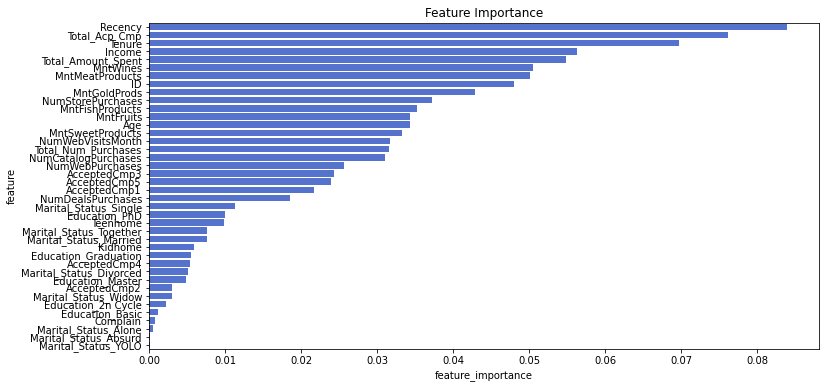

In [82]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

### Boruta

In [83]:
#  training and test dataset for Boruta
X_boruta = X_train.values
y_boruta = y_train.values.ravel()

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	40
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	5
Rejected: 	28
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	5
Rejected: 	28
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	5
Rejected: 	28
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	5
Rejected: 	28
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	30
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	30
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	30
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	30
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	30
I

In [84]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = X_train.iloc[: , cols_selected].columns.to_list()

# features not selected
cols_not_selected_boruta = list(np.setdiff1d( X_train.columns, cols_selected))

cols_selected_boruta

['Income',
 'Recency',
 'MntWines',
 'MntMeatProducts',
 'Tenure',
 'Total_Amount_Spent',
 'Total_Acp_Cmp']

### Final Selection of Features

In [85]:
# Based on EDA and both feature selectors:

cols_selected = ['Income',
 'Recency',
 'MntWines',
 'MntMeatProducts',
 'Tenure',
 'Total_Amount_Spent',
 'Total_Acp_Cmp', 
 'MntGoldProds',
 'Total_Num_Purchases',
 'NumDealsPurchases',
 'NumWebVisitsMonth']

# STEP 07 - Machine Learning Modelling - Classification

In [86]:
# train data with selected features from Feature Selection
x_train = X_train[cols_selected]

# test data with selected features from Feature Selection
x_test = X_test[cols_selected]

## Check data balance

Text(0.5, 1.0, 'No data balance applied')

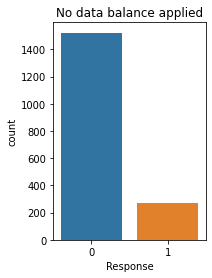

In [87]:
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("No data balance applied")

The target variable is imbalanced as shown in the plot above, balancing the data is a step that can be done in the next CRISP cycle, so the classification algorithm can detect different classes more accurately and make difficult for the model to become biased towards prediction.


## Classification Models

In classification problems, usually the metrics to measure the performance are precision adn recall. However, the precision is not the best metric to evaluate this work, because we are not interested in classificion, but rather an ordered list of class 1 (Response=1) probabilities. These probalities can be evaluated using the cumulative gain plot.

Cumulative Gain: Gain is a measure of the effectiveness of a classification model calculated as the ration between the results obtained with and without the model.

### Logistic Regression

In [88]:
# Model definition
lr = LogisticRegression()

# Train
lr.fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict_proba(x_test)

# model performance with performance function
lr_model_performance = performance(lr, x_train, y_train)
lr_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score
0,0.886533,0.78632,0.333333,0.462785


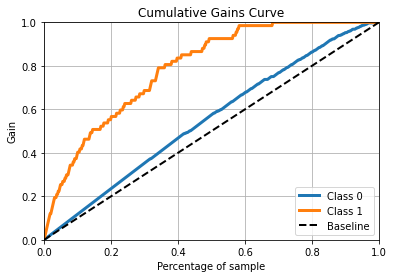

In [89]:
# LR Cumulative Gain Plot

skplt.metrics.plot_cumulative_gain(y_test, yhat_lr)
plt.show()

In [90]:
# include 'ID' column to obtain the ids with the probabilities

cols_selected_ml = ['ID',
 'Income',
 'Recency',
 'MntWines',
 'MntMeatProducts',
 'Tenure',
 'Total_Amount_Spent',
 'Total_Acp_Cmp', 
 'MntGoldProds',
 'Total_Num_Purchases',
 'NumDealsPurchases',
 'NumWebVisitsMonth']

x_test_n = X_test[cols_selected_ml]

In [91]:
df_lr_model = x_test_n.copy()
df_lr_model['Response'] = y_test.copy()

# Create score column base on probabilites calculated to response equal to 1
df_lr_model['score'] = yhat_lr[:, 1].tolist() 
df_lr_model = df_lr_model.sort_values('score', ascending=False)  
df_lr_model.head()

,ID,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumDealsPurchases,NumWebVisitsMonth,Response,score
1845,7872,0.529704,0.070707,0.119893,0.158261,0.937053,0.219048,0.75,0.174033,0.522727,0.066667,0.25,1,0.959682
1710,477,0.509016,0.313131,0.709980,0.484058,0.017167,0.853968,1.00,0.279006,0.500000,0.066667,0.05,1,0.905615
1087,1509,0.514916,0.808081,0.101808,0.059710,0.773963,0.205556,1.00,0.223757,0.500000,0.000000,0.25,1,0.882046
1301,6024,0.576683,0.626263,0.744139,0.457971,0.689557,0.911508,0.75,0.475138,0.409091,0.000000,0.10,1,0.880194
591,7627,0.562860,0.252525,0.547220,0.462029,0.806867,0.825794,0.50,0.055249,0.477273,0.000000,0.10,1,0.862002


In [93]:
x_test.shape # size of the test dataframe

(448, 11)

In [95]:
# As the test data contains 448 customers (rows), the performance will be evaluated as 50% of the dataset.

In [96]:
precision_at_k(df_lr_model, model_name='Logistic Regression') 

Model: Logistic Regression 
Ranking Position: 224 
Precison: 0.28


In [135]:
response_rate_lr = round(df_lr_model['Response'][:224].sum() / df_lr_model['Response'].sum() * 100)
print('With 224 calls, the sales team will have approximately {:,.2f}% of potential customers interested in the offer'.format(response_rate_lr))

With 224 calls, the sales team will have approximately 93.00% of potential customers interested in the offer


### KNN

In [99]:
# Model definition
knn = KNeighborsClassifier()

# Train
knn.fit(x_train, y_train)

# Prediction
yhat_knn = knn.predict_proba(x_test)

# model performance with performance function
knn_model_performance = performance(knn, x_train, y_train)
knn_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score
0,0.866961,0.589719,0.341738,0.431025


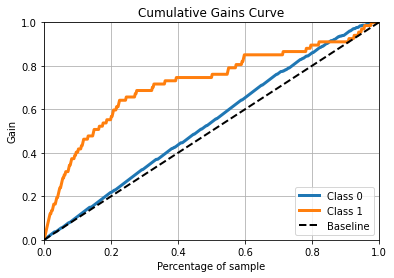

In [100]:
# KNN Cumulative Gain Plot

skplt.metrics.plot_cumulative_gain(y_test, yhat_knn)
plt.show()

In [101]:
df_knn_model = x_test_n.copy()
df_knn_model['Response'] = y_test.copy()

# Create score column base on probabilites calculated to response equal to 1
df_knn_model['score'] = yhat_knn[:, 1].tolist() 
df_knn_model = df_knn_model.sort_values('score', ascending=False)  
df_knn_model.head()

,ID,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumDealsPurchases,NumWebVisitsMonth,Response,score
124,7215,0.623899,0.696970,0.483590,0.059130,0.678112,0.448413,0.75,0.464088,0.613636,0.000000,0.10,1,1.0
1845,7872,0.529704,0.070707,0.119893,0.158261,0.937053,0.219048,0.75,0.174033,0.522727,0.066667,0.25,1,1.0
1153,5031,0.506731,0.141414,0.520429,0.423768,0.922747,0.725397,0.25,0.314917,0.590909,0.066667,0.10,1,1.0
1087,1509,0.514916,0.808081,0.101808,0.059710,0.773963,0.205556,1.00,0.223757,0.500000,0.000000,0.25,1,1.0
60,6853,0.460872,0.121212,0.476892,0.311884,0.515021,0.568651,0.50,0.220994,0.477273,0.066667,0.05,1,1.0


In [103]:
precision_at_k(df_knn_model, model_name='KNeighborsClassifier')

Model: KNeighborsClassifier 
Ranking Position: 224 
Precison: 0.22


In [133]:
response_rate_knn = round(df_knn_model['Response'][:224].sum() / df_knn_model['Response'].sum() * 100)
print('With 224 calls, the sales team will have approximately {:,.2f}% of potential customers interested in the offer'. format(response_rate_knn))

With 224 calls, the sales team will have approximately 73.00% of potential customers interested in the offer


### Extra Trees Classifier

In [104]:
# Model definition
et = ExtraTreesClassifier()

# Train
et.fit(x_train, y_train)

# Prediction
yhat_et = et.predict_proba(x_test) 

# model performance with performance function
et_model_performance = performance(et, x_train, y_train)
et_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score
0,0.889885,0.753942,0.404701,0.520386


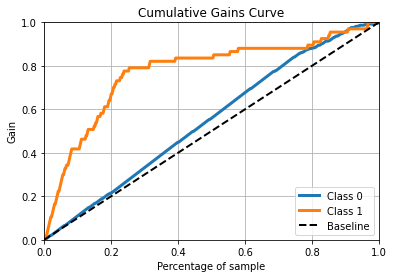

In [105]:
# ET Cumulative Gain Plot

skplt.metrics.plot_cumulative_gain(y_test, yhat_et)
plt.show()

In [106]:
df_et_model = x_test_n.copy()
df_et_model['Response'] = y_test.copy()

# Create score column base on probabilites calculated to response equal to 1
df_et_model['score'] = yhat_et[:, 1].tolist() 
df_et_model = df_et_model.sort_values('score', ascending=False)  
df_et_model.head()

,ID,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumDealsPurchases,NumWebVisitsMonth,Response,score
1803,4168,0.219958,0.303030,0.154722,0.079420,0.666667,0.169841,0.00,0.107735,0.522727,0.600000,0.35,1,1.0
1981,8524,0.148002,0.151515,0.026792,0.017391,0.928469,0.038095,0.00,0.030387,0.204545,0.200000,0.45,1,1.0
1063,2055,0.212427,0.373737,0.010047,0.004638,0.058655,0.017460,0.25,0.055249,0.136364,0.133333,0.25,0,1.0
1669,4127,0.473252,0.979798,0.672472,0.153623,0.703863,0.604762,0.25,0.074586,0.772727,0.133333,0.30,1,1.0
1502,3340,0.250730,0.565657,0.163429,0.062609,0.974249,0.171032,0.00,0.138122,0.454545,0.400000,0.40,1,1.0


In [107]:
precision_at_k(df_et_model, model_name='ExtraTreesClassifier')

Model: ExtraTreesClassifier 
Ranking Position: 224 
Precison: 0.25


In [134]:
response_rate_et = round(df_et_model['Response'][:224].sum() / df_et_model['Response'].sum() * 100)
print('With 224 calls, the sales team will have approximately {:,.2f}% of potential customers interested in the offer'.format(response_rate_et))

With 224 calls, the sales team will have approximately 84.00% of potential customers interested in the offer


# STEP 08 - Convert Model Performance to Business Values - Classification

## Model Performance - Training

In [109]:
performance_all = pd.concat([lr_model_performance, knn_model_performance, et_model_performance])
performance_all.columns = ['accuracy', 'precision', 'recall', 'f1_score']
performance_all['model'] = ['Logistic Regression', 'KNN','Extra Trees']
performance_all = performance_all[['model', 'accuracy', 'precision', 'recall', 'f1_score']]
performance_all.set_index('model')

,accuracy,precision,recall,f1_score
model,,,,
Logistic Regression,0.886533,0.786320,0.333333,0.462785
KNN,0.866961,0.589719,0.341738,0.431025
Extra Trees,0.889885,0.753942,0.404701,0.520386


## Model Performance - Test

In [110]:
lr_model_performance_test = performance_test('Logistic Regression', lr, x_test, y_test)
knn_model_performance_test = performance_test('KNN', knn, x_test, y_test)
et_model_performance_test = performance_test('Extra Trees', et, x_test, y_test)
model_performance_comparison_test = pd.concat([lr_model_performance_test, knn_model_performance_test , et_model_performance_test])

model_performance_comparison_test

,precision,recall,f1_score
Logistic Regression,0.655172,0.283582,0.395833
KNN,0.700000,0.313433,0.432990
Extra Trees,0.766667,0.343284,0.474227


As said before, the main goal is not to classify but to choose the model that have more probability of customers that will accept the offer with lower cost. So, the chosen model was Linear Regression because it showed a better result of conversion propability (93%) using only 50% of customers.



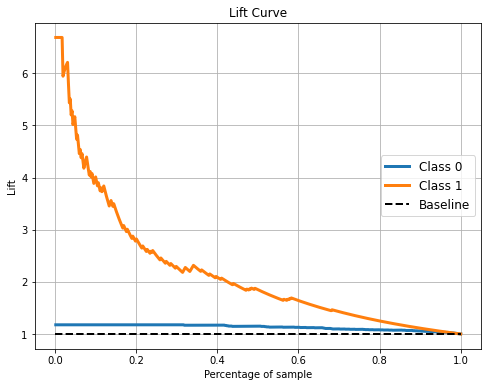

In [111]:
# plot Lift curve
skplt.metrics.plot_lift_curve(y_test, yhat_lr, figsize=(8,6))
plt.legend(loc='center right', fontsize=12)
plt.show()

The lift chart provides an easy way to visualize how many times better applying the model is than random selection for any percentage of the ranked records. The greater the area between the lift curve and the baseline, the better the model. With 50% of sample of customers we almost hit a 2 times better result than without the model.


## Business Performance

In [112]:
num_customer_acp_cmp = 0.15*df1.shape[0]
num_customer_contacted = df1.shape[0]

print('For the company to have a 15% response rate, means that {} of the customers accepted the offer \
of all {} that were contacted.'.format(num_customer_acp_cmp, num_customer_contacted))

For the company to have a 15% response rate, means that 336.0 of the customers accepted the offer of all 2240 that were contacted.


In [113]:
print('The model has a precision of {:,.2f}% in labelling customers that have a high probability of '\
'accepting the offer  if only 50% of the customers were contacted.'.format(response_rate_lr))

The model has a precision of 93.00% in labelling customers that have a high probability of accepting the offer  if only 50% of the customers were contacted.


In [136]:
produc_value = (3674/num_customer_acp_cmp)
num_customer_acp_model = df1.shape[0]*0.5*0.93
pred_revenue = num_customer_acp_model*produc_value

print('If the company uses this model and contact only 50% of the custumer list, which accounts for {:,.2f} customers, '\
      ' the revenue prediction would be {:,.2f}MU.'.format(num_customer_acp_model, pred_revenue))

If the company uses this model and contact only 50% of the custumer list, which accounts for 1,041.60 customers,  the revenue prediction would be 11,389.40MU.


# STEP 09 - Machine Learning Modelling - Clustering

The method that is going to be used is K-means, since the features have diffrent dimensions the dataset used is going to be the rescaled one.

## Data

In [115]:
df_cluster = df6.copy() 

In [116]:
df_cluster = df_cluster[cols_selected_ml]

df_cluster.head()

,ID,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumDealsPurchases,NumWebVisitsMonth
0,5524,0.351086,0.585859,0.425318,0.316522,0.948498,0.639683,0.0,0.243094,0.568182,0.200000,0.35
1,2174,0.277680,0.383838,0.007368,0.003478,0.161660,0.008730,0.0,0.016575,0.136364,0.133333,0.25
2,4141,0.434956,0.262626,0.285332,0.073623,0.446352,0.305952,0.0,0.116022,0.477273,0.066667,0.20
3,6182,0.155079,0.262626,0.007368,0.011594,0.198856,0.019048,0.0,0.013812,0.181818,0.133333,0.30
4,5324,0.352051,0.949495,0.115874,0.068406,0.230329,0.165476,0.0,0.041436,0.431818,0.333333,0.25


## Setting up environment

In [117]:
from pycaret.clustering import *

In [118]:
cluster = setup(df_cluster,
              normalize=True,
              transformation=False,
              session_id=1,
              n_jobs=-1)

,Description,Value
0,session_id,1
1,Original Data,"(2237, 12)"
2,Missing Values,0
3,Numeric Features,12
4,Categorical Features,0
5,Ordinal Features,0
6,High Cardinality Features,0
7,High Cardinality Method,None
8,Transformed Data,"(2237, 12)"
9,CPU Jobs,-1


## Create Model

In [119]:
kmeans = create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2284,701.0514,1.7963,0,0,0


In [120]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)


## Assign a Model

In [121]:
df_kmean_results = assign_model(kmeans)
df_kmean_results.head()

,ID,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumDealsPurchases,NumWebVisitsMonth,Cluster
0,5524,0.351086,0.585859,0.425318,0.316522,0.948498,0.639683,0.0,0.243094,0.568182,0.200000,0.35,Cluster 2
1,2174,0.277680,0.383838,0.007368,0.003478,0.161660,0.008730,0.0,0.016575,0.136364,0.133333,0.25,Cluster 0
2,4141,0.434956,0.262626,0.285332,0.073623,0.446352,0.305952,0.0,0.116022,0.477273,0.066667,0.20,Cluster 2
3,6182,0.155079,0.262626,0.007368,0.011594,0.198856,0.019048,0.0,0.013812,0.181818,0.133333,0.30,Cluster 0
4,5324,0.352051,0.949495,0.115874,0.068406,0.230329,0.165476,0.0,0.041436,0.431818,0.333333,0.25,Cluster 2


## Plot Model

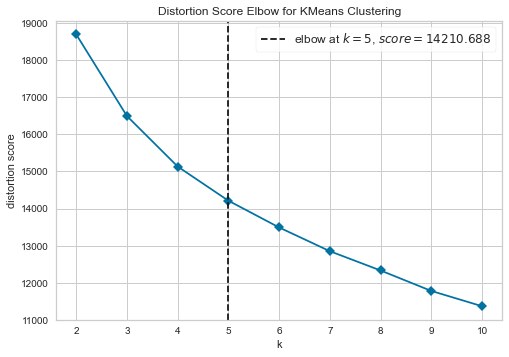

In [122]:
# Elbow

plot_model(kmeans, plot = 'elbow')

In [123]:
kmeans_5 = create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1416,496.0622,1.943,0,0,0


In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. In our case, the elbow method shows that the ideal number of clusters is 5. However, visually the elbow plot it is better to choose k=3. Also, the silhoutte score for k=3 (0.2284) clusters was better than for k=5 (0.1416).

For a clusterization, it is better to have a higher silhoutte score because it means that the clusters are more distant form each other e cohesive to its own cluster.

In [137]:
# PCA


plot_model(kmeans)

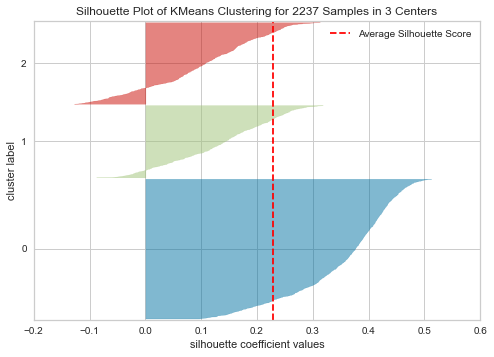

In [126]:
# Sihlouette

plot_model(kmeans, plot = 'silhouette')

In [127]:
# Distribution

plot_model(kmeans, plot = 'distribution') #to see size of clusters

# STEP 10 - Convert Model Performance to Business Values - Clustering

In [128]:
df_clusters = pd.merge(df4, df_kmean_results[['ID','Cluster']], how='left', on='ID')
df_clusters.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Tenure,Total_Amount_Spent,Total_Num_Purchases,Total_Acp_Cmp,Cluster
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,...,0,0,0,1,57,1.815232,1617,25,0,Cluster 2
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,...,0,0,0,0,60,0.309383,27,6,0,Cluster 0
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,...,0,0,0,0,49,0.854227,776,21,0,Cluster 2
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,...,0,0,0,0,30,0.380569,53,8,0,Cluster 0
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,...,0,0,0,0,33,0.440803,422,19,0,Cluster 2


In [129]:
aux_1 = df_clusters[['Income','Cluster']].groupby('Cluster').mean().reset_index()

aux_2 = df_clusters[['Recency','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2 = pd.merge(aux_1, aux_2, how='inner', on='Cluster')

aux_3 = df_clusters[['MntWines','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3 = pd.merge(aux_1_2, aux_3, how='inner', on='Cluster')

aux_4 = df_clusters[['MntMeatProducts','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4 = pd.merge(aux_1_2_3, aux_4, how='inner', on='Cluster')

aux_5 = df_clusters[['Tenure','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5 = pd.merge(aux_1_2_3_4, aux_5, how='inner', on='Cluster')

aux_6 = df_clusters[['Total_Amount_Spent','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6 = pd.merge(aux_1_2_3_4_5, aux_6, how='inner', on='Cluster')

aux_7 = df_clusters[['Total_Acp_Cmp','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6_7 = pd.merge(aux_1_2_3_4_5_6, aux_7, how='inner', on='Cluster')

aux_8 = df_clusters[['MntGoldProds','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6_7_8 = pd.merge(aux_1_2_3_4_5_6_7, aux_8, how='inner', on='Cluster')

aux_9 = df_clusters[['Total_Num_Purchases','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6_7_8_9 = pd.merge(aux_1_2_3_4_5_6_7_8, aux_9, how='inner', on='Cluster')

aux_10 = df_clusters[['NumWebVisitsMonth','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6_7_8_9_10 = pd.merge(aux_1_2_3_4_5_6_7_8_9, aux_10, how='inner', on='Cluster')

aux_11 = df_clusters[['NumDealsPurchases','Cluster']].groupby('Cluster').mean().reset_index()

aux_1_2_3_4_5_6_7_8_9_10_11 = pd.merge(aux_1_2_3_4_5_6_7_8_9_10, aux_11, how='inner', on='Cluster')


df_cluster_features = aux_1_2_3_4_5_6_7_8_9_10_11

df_cluster_features

,Cluster,Income,Recency,MntWines,MntMeatProducts,Tenure,Total_Amount_Spent,Total_Acp_Cmp,MntGoldProds,Total_Num_Purchases,NumWebVisitsMonth,NumDealsPurchases
0,Cluster 0,35655.527700,49.112676,47.746479,25.192488,0.855962,108.904225,0.082629,15.637559,8.074178,6.295775,1.886385
1,Cluster 1,77912.644283,50.317604,651.007260,466.263158,0.925378,1413.430127,0.802178,77.609800,20.362976,2.704174,1.172414
2,Cluster 2,56867.024960,48.014493,435.560386,144.367150,1.200283,741.167472,0.219002,62.706924,21.653784,5.964573,4.106280


The data above shows that it is possible to adress the clusters with the Income feature.

* Cluster 0: Income mean of 35k (Lower class)
* Cluster 1: Income mean of 78k (Upper class)
* Cluster 2: Income mean of 56k (Middle class)

# Conclusions

**1. Predictive Model**  

With the use of the model in production, the company can improve the offer acceptance from marketing campaigns for selling a new gadget. This is because the company only needs to contact 50% of customers to get over 93% conversion. 

**2. Exploratory Data Analysis**

From the EDA, the features that have the most impact in model predictions are: 

Income, Total number of purchases,Total number of accepted campaigns and Total amount spent.

So, the marketing team should consider them as an important feature when planning a campaign.

**3. Customer Segmentation**

From the customer segmentation, we have 3 clusters that are defined by its money income.

As for that, we see that for the upper class, they tend to buy as much as the middle class (Total_Num_Purchases) but they buy more expensive products (Total_Amount_Spent, MntGoldProds, MntMeatProducts, MntWines). On the other hand, the lower class they buy cheaper products and fewer time than the other classes.
   
The lower class and the middle class have almost the same average number of visits on the website, but the upper class do not visit that much. This can be used when directing a marketing campaign for this public.
   
The number of purchases with discount is very high for the customers labeled as middle class, but this practice is not frequently done by the low and upper class. 
   
Finally, the group that has more chances of buying is the upper class, representing an average of total number of accepted campaigns of 0.8, followed by the middle class (0.21) and the lower class (0.08).

Focusing the marketing campaigns for the upper class would be more valuable for the company. Nonetheless, targeting the lower class customers is not ideal for this campaign. 
   

# Next Steps

* Treat outliers
* Try more machine learning models
* Fine tuning of parameters of models
* Data balance